In [2]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection  import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

In [3]:
data = pd.read_csv('/volumes/KESU/Kobe_Bryant_Shot_Selection/dataset/data.csv')

data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [20]:
data.shape

(30697, 24)

In [4]:
data.describe(include=['number'])

,lat,loc_x,loc_y,lon,minutes_remaining,seconds_remaining,shot_distance
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,7.110499,91.107535,-118.262690,4.885624,28.365085,13.437437
std,0.087791,110.124578,87.791361,0.110125,3.449897,17.478949,9.374189
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,0.000000,0.000000
25%,33.884300,-68.000000,4.000000,-118.337800,2.000000,13.000000,5.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,28.000000,15.000000
75%,34.040300,95.000000,160.000000,-118.174800,8.000000,43.000000,21.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,59.000000,79.000000


In [5]:
data.describe(include=['object', 'category'])

,action_type,combined_shot_type,game_event_id,game_id,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,25697.0,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,620,1559,7,2,20,2.0,2,6,7,5,1,1,1559,74,33
top,Jump Shot,Jump Shot,2,21501228,3,0,2005-06,0.0,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,132,50,8296,26198,2318,14232.0,24271,13455,12625,9398,30697,30697,50,1020,1978


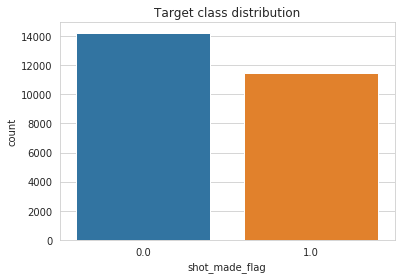

In [6]:
ax = plt.axes()
sns.countplot(x='shot_made_flag', data=data, ax=ax);
ax.set_title('Target class distribution')
plt.show()

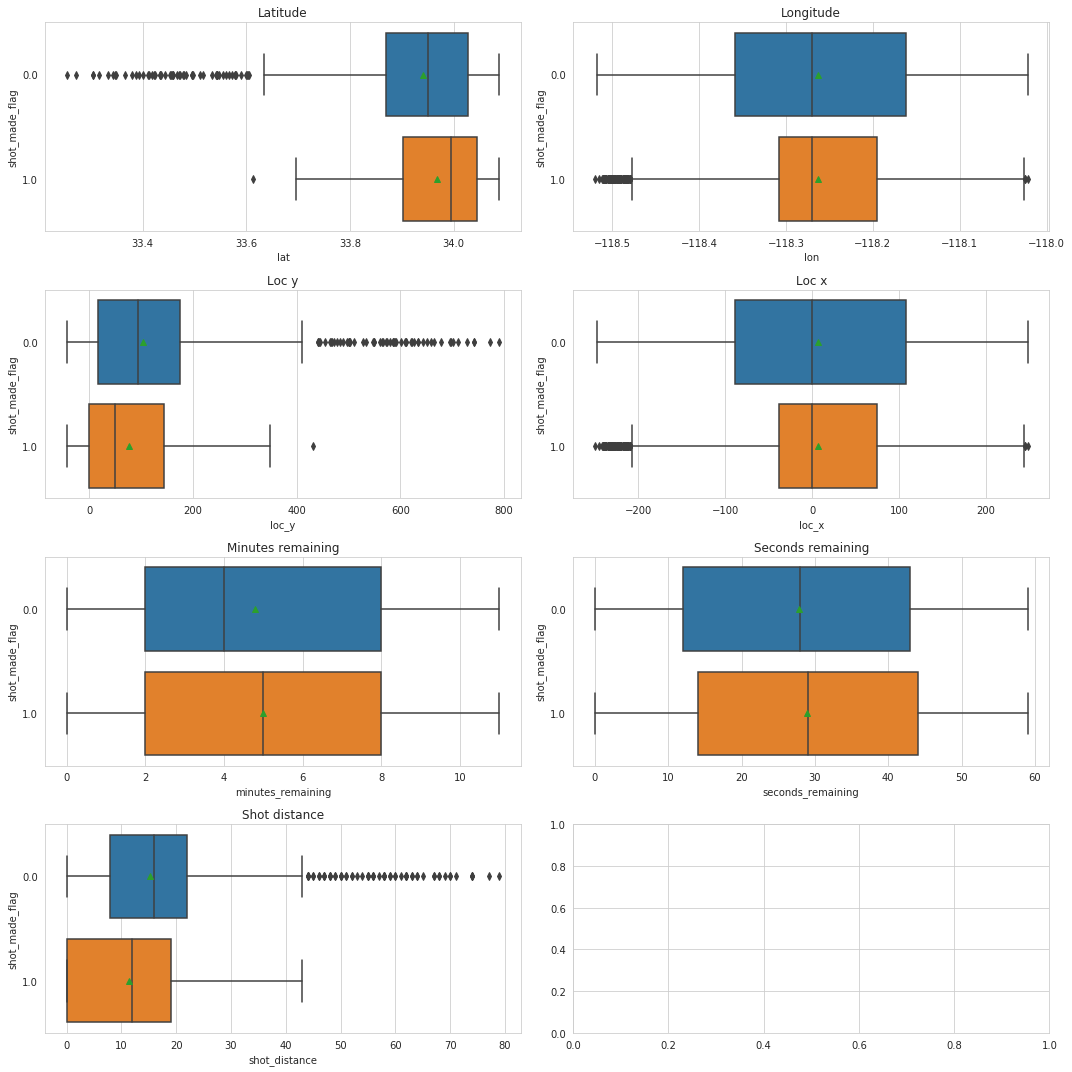

In [7]:

f, axarr = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(x='lat', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0,0])
sns.boxplot(x='lon', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 1])
sns.boxplot(x='loc_y', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 0])
sns.boxplot(x='loc_x', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 1])
sns.boxplot(x='minutes_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 0])
sns.boxplot(x='seconds_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 1])
sns.boxplot(x='shot_distance', y='shot_made_flag', data=data, showmeans=True, ax=axarr[3, 0])

axarr[0, 0].set_title('Latitude')
axarr[0, 1].set_title('Longitude')
axarr[1, 0].set_title('Loc y')
axarr[1, 1].set_title('Loc x')
axarr[2, 0].set_title('Minutes remaining')
axarr[2, 1].set_title('Seconds remaining')
axarr[3, 0].set_title('Shot distance')

plt.tight_layout()
plt.show()

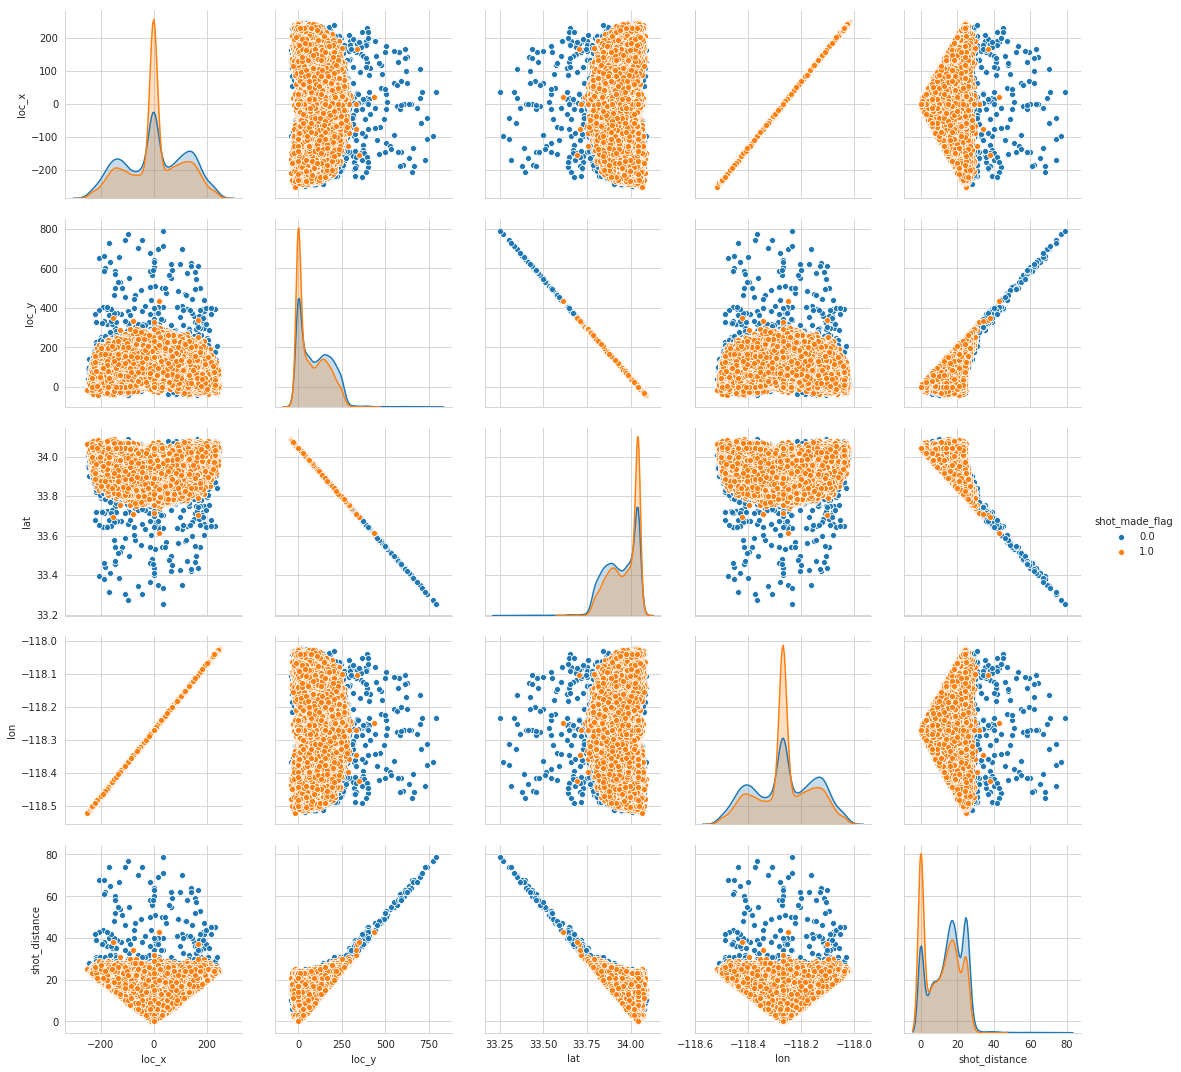

In [8]:
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=3)

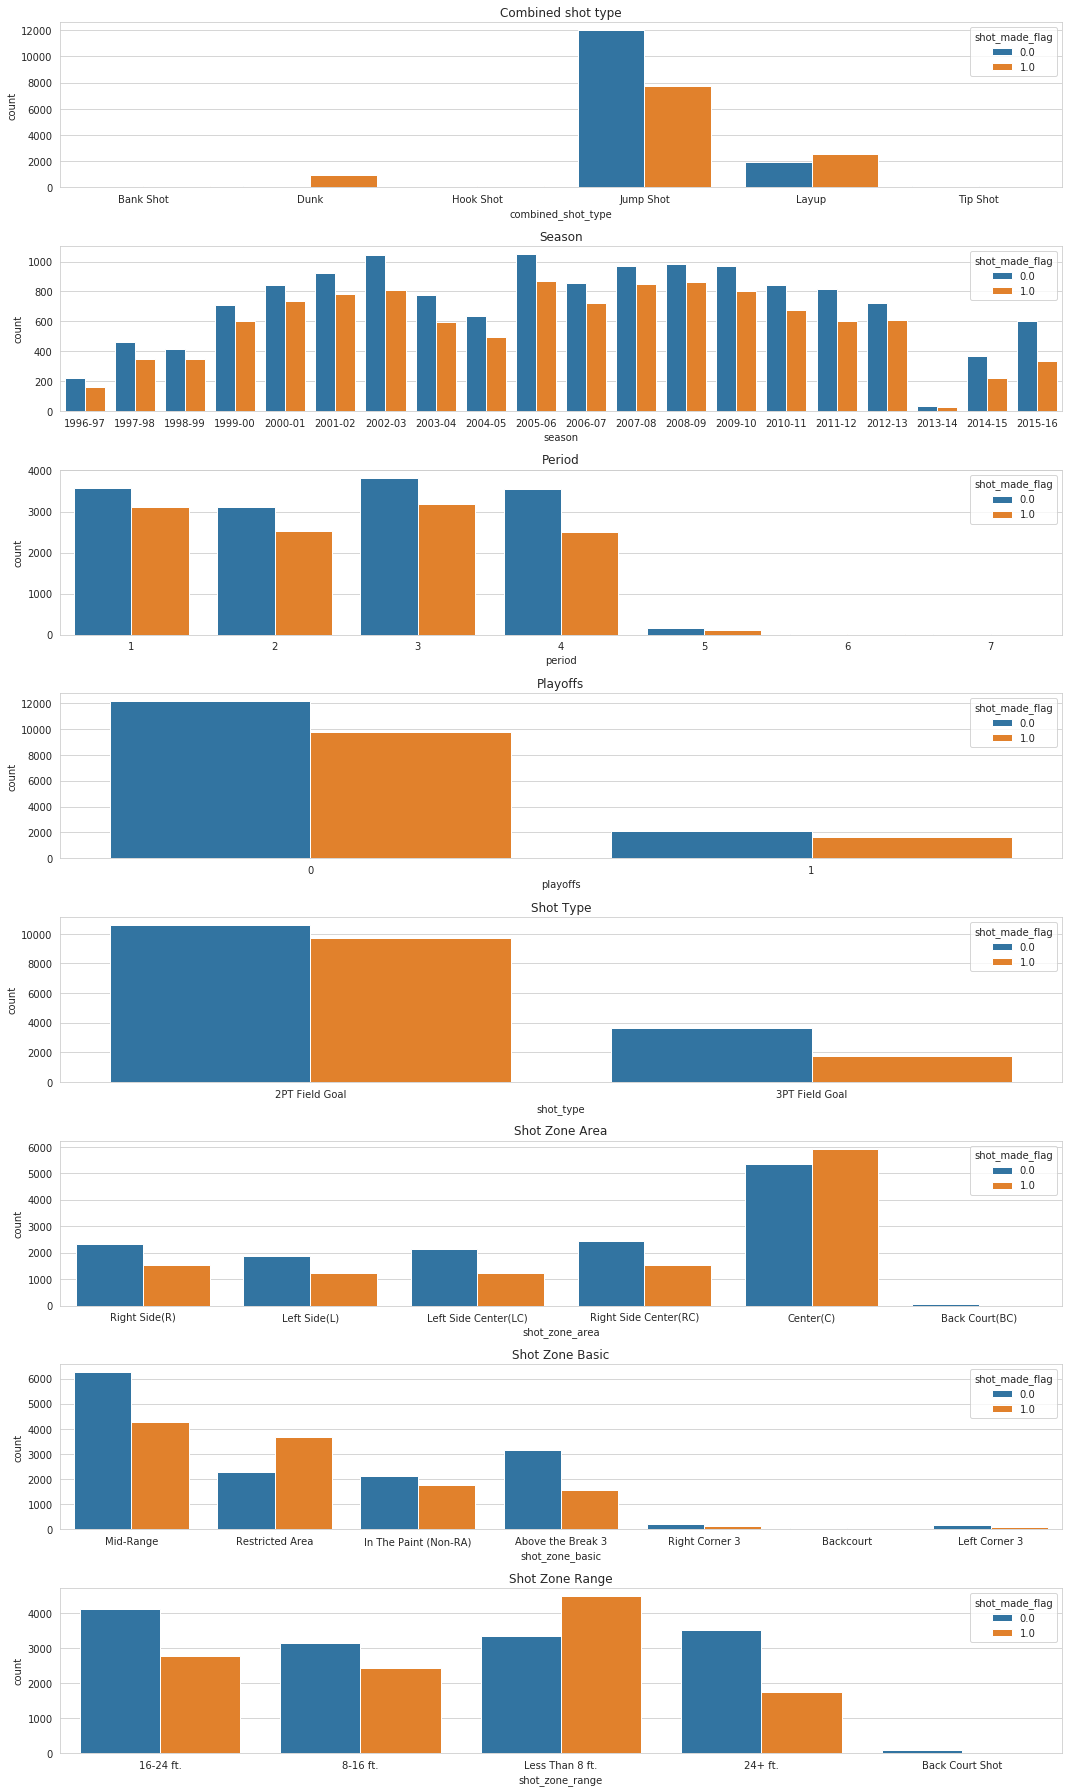

In [9]:
f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=data, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=data, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=data, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data, ax=axarr[7])

axarr[0].set_title('Combined shot type')
axarr[1].set_title('Season')
axarr[2].set_title('Period')
axarr[3].set_title('Playoffs')
axarr[4].set_title('Shot Type')
axarr[5].set_title('Shot Zone Area')
axarr[6].set_title('Shot Zone Basic')
axarr[7].set_title('Shot Zone Range')

plt.tight_layout()

In [10]:
unknown_mask = data['shot_made_flag'].isnull()

In [11]:
data_cl = data.copy() # create a copy of data frame
target = data_cl['shot_made_flag'].copy()

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True)

In [12]:

def detect_outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))

## For now - do not remove anything

In [13]:
# Remaining time
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5

data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Game date
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl['game_month'] = data_cl['game_date'].dt.month
data_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

In [14]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [15]:
# Separate dataset for validation
data_submit = data_cl[unknown_mask]

# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

In [16]:
threshold = 0.90
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = data_cl.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

Index(['playoffs', 'shot_distance', 'home_play', 'action_type#Jump Shot',
       'combined_shot_type#Jump Shot', 'combined_shot_type#Layup', 'period#1',
       'period#2', 'period#3', 'period#4', 'shot_type#2PT Field Goal',
       'shot_type#3PT Field Goal', 'shot_zone_area#Center(C)',
       'shot_zone_area#Left Side Center(LC)', 'shot_zone_area#Left Side(L)',
       'shot_zone_area#Right Side Center(RC)', 'shot_zone_area#Right Side(R)',
       'shot_zone_basic#Above the Break 3',
       'shot_zone_basic#In The Paint (Non-RA)', 'shot_zone_basic#Mid-Range',
       'shot_zone_basic#Restricted Area', 'shot_zone_range#16-24 ft.',
       'shot_zone_range#24+ ft.', 'shot_zone_range#8-16 ft.',
       'shot_zone_range#Less Than 8 ft.', 'game_month#1', 'game_month#2',
       'game_month#3', 'game_month#4', 'game_month#11', 'game_month#12',
       'loc_x#(-10.96, 8.96]', 'loc_y#(-10.6, 22.8]', 'loc_y#(22.8, 56.2]',
       'loc_y#(123.0, 156.4]'],
      dtype='object')

In [17]:
model = RandomForestClassifier()
model.fit(X, Y)

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index(['shot_distance', 'action_type#Jump Shot', 'home_play',
       'combined_shot_type#Dunk', 'period#2', 'period#3', 'period#4',
       'period#1', 'game_month#1', 'game_month#3', 'game_month#2',
       'game_month#4', 'action_type#Driving Layup Shot', 'loc_y#(-10.6, 22.8]',
       'game_month#12', 'game_month#11', 'action_type#Layup Shot', 'playoffs',
       'opponent#PHX', 'opponent#SAS'],
      dtype='object')

In [19]:
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, Y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

TypeError: data type not understood

In [ ]:
rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, Y)

feature_rfe_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })

feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_20

In [ ]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20,
        feat_scored_20,
        feat_rfe_20
    ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

In [ ]:
data_cl = data_cl.ix[:, features]
data_submit = data_submit.ix[:, features]
X = X.ix[:, features]

print('Clean dataset shape: {}'.format(data_cl.shape))
print('Subbmitable dataset shape: {}'.format(data_submit.shape))
print('Train features shape: {}'.format(X.shape))
print('Target label shape: {}'. format(Y.shape))

In [ ]:
components = 8
pca = PCA(n_components=components).fit(X)

In [ ]:
pca_variance_explained_df = pd.DataFrame({
    "component": np.arange(1, components+1),
    "variance_explained": pca.explained_variance_ratio_            
    })

ax = sns.barplot(x='component', y='variance_explained', data=pca_variance_explained_df)
ax.set_title("PCA - Variance explained")
plt.show()